In [1]:
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path

r = Path('/home/rens/hpc/PREMIUM histopathology/data_annotations/isala/annotations')

file = list(r.iterdir())[1]
with open(file, 'r') as f:
    xml_file = ET.parse(f)

rois = []
for annotation in xml_file.getroot()[0]:
    roi = []
    for coordinate in annotation[0]:
        roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
    rois.append(np.array(roi).astype(float).astype(int))


In [2]:
import cv2

mask = np.zeros((50688,84480))
cv2.fillPoly(mask, rois,1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

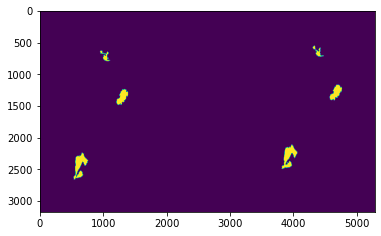

(3168, 5280)

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

reduced_mask = zoom(mask, 1/16, mode='nearest', order=0)

plt.imshow(reduced_mask)
plt.show()
reduced_mask.shape

In [9]:
import openslide

slide_r = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis')

slide = openslide.OpenSlide(str(slide_r / (file.stem + '.ndpi')))

In [11]:
img = np.array(slide.read_region((0,0), 4, slide.level_dimensions[4]).convert('RGB'))

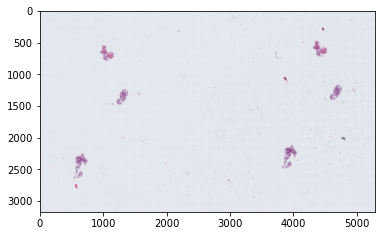

(3168, 5280, 3)

In [12]:
plt.imshow(img)
plt.show()
img.shape

In [ ]:
import sys
import cv2
import torch
import geojson
import openslide
import numpy as np
import xml.etree.ElementTree as ET
from pytorch_lightning import LightningModule
from monai.transforms import Lambdad, Compose, ToTensord
from monai.data import CacheDataset
from torch.utils.data import DataLoader
from util import format_output, output2annotations, normalize_staining
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
from pytorch_lightning import Trainer
from pathlib import Path

sys.path.insert(1, '/home/rens/repos/hover_net')

from models.hovernet.net_desc import HoVerNet


class Processor(LightningModule):
    def __init__(self, slide_path):
        super().__init__()

        # setup hovernet
        self.net = HoVerNet(nr_types=6,mode='fast')
        ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
        self.net.load_state_dict(ckpt['desc'], strict=True)

        # open slide
        self.slide = openslide.OpenSlide(str(slide_path))
        dimensions = np.array(self.slide.level_dimensions)

        # create mask
        image = np.array(self.slide.read_region((0,0), 3, self.slide.level_dimensions[3]).convert('RGB'))
        mask = image.sum(axis=-1) < 650
        filled_mask = binary_fill_holes(mask)
        # eroded_mask = binary_erosion(filled_mask, iterations=50)

        # create and filter list of origins which will be inferenced
        xx = np.arange(0,self.slide.dimensions[0], 164)[:-1]
        yy = np.arange(0,self.slide.dimensions[1], 164)[:-1]

        origins = np.array([(x,y) for y in yy for x in xx])
        downsampled_origins = (origins / dimensions[0] * dimensions[3]).astype(int)
        filtered_origins = origins[[filled_mask[y,x] for x,y in downsampled_origins]]

        # self.input is the input to the dataset
        self.input = [{'origin':origin, 'image':origin} for origin in filtered_origins]

        # output classes
        self.classes = {
            0 : "nolabe",
            1 : "neopla",
            2 : "inflam",
            3 : "connec",
            4 : "necros",
            5 : "no-neo",
        }

        # list for storing outputted annotations
        self.output = []

    def forward(self, x):
        return self.net(x)

    def test_dataloader(self):
        ds = CacheDataset(
            self.input,
            transform=Compose([
                Lambdad(
                    keys='image', 
                    func=lambda x: np.array(processor.slide.read_region(
                        (x[0] - 46, x[1] - 46),
                        0,
                        (256,256)
                    ).convert('RGB'))
                ),
                Lambdad(
                    keys='image',
                    func=lambda x: normalize_staining(x)[0]
                ),
                Lambdad(
                    keys='image', 
                    func = lambda x: x.transpose(2,0,1)
                ),
                ToTensord(keys='image')
            ]),
            cache_rate=0.01
        )

        return DataLoader(ds, batch_size=16)

    def test_step(self, batch, batch_ix):
        origins, images, _ = batch.values()
        output = self.net(images)

        for k in output.keys():
            output[k] = output[k].detach().cpu()

        formatted_output = format_output(output)
        annotations = [output2annotations(pred) for pred in formatted_output]
        
        for origin, annotation in zip(origins, annotations):
            for instance in annotation.values():
                dict_data = {}

                cc = (origin.cpu().numpy() + instance['contour']).tolist()
                cc.append(cc[0])

                dict_data["type"]="Feature"
                dict_data["id"]="PathCellObject"
                dict_data["geometry"]={
                    "type":"Polygon",
                    "coordinates":[cc]
                }
                dict_data["properties"]={
                    "isLocked":"false",
                    "measurements":[],
                    "classification": {
                        "name": self.classes[instance['type']]
                    }
                }

                self.output.append(dict_data)

    def save(self, save_path):
        with open(save_path, 'w') as file:
            geojson.dump(self.output, file)


slide_dir = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis')
output_dir = Path('/home/rens/hpc/rens/output/hovernet_re_output_normalized')

for file in list(slide_dir.iterdir()):
    print(file)


    processor = Processor(
        file
    )

    trainer = Trainer(gpus=1)
    trainer.test(processor)

    save_path = output_dir / (file.stem + '.json')

    processor.save(save_path)